In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from dash import Dash, dcc, html, dash_table
import dash_bootstrap_components as dbc
from dash.dependencies import Output, Input
from dash.exceptions import PreventUpdate
from dash_bootstrap_templates import load_figure_template
import dash_dangerously_set_inner_html
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

from support_functions import (
    calculate_total_recovery, 
    create_thousand_dataframe,     
    resample_data, 
    find_free_port,
    create_metrics,
    find_highest_ridership_day,
    calculate_yoy_growth,
    calculate_manual_recovery,
    create_kpis
)

In [6]:
mta_data = pd.read_csv('./data/MTA_Daily_Ridership.csv',parse_dates=['Date'])

In [7]:
mta_data.head()

,Date,Subways: Total Estimated Ridership,Subways: % of Comparable Pre-Pandemic Day,Buses: Total Estimated Ridership,Buses: % of Comparable Pre-Pandemic Day,LIRR: Total Estimated Ridership,LIRR: % of Comparable Pre-Pandemic Day,Metro-North: Total Estimated Ridership,Metro-North: % of Comparable Pre-Pandemic Day,Access-A-Ride: Total Scheduled Trips,Access-A-Ride: % of Comparable Pre-Pandemic Day,Bridges and Tunnels: Total Traffic,Bridges and Tunnels: % of Comparable Pre-Pandemic Day,Staten Island Railway: Total Estimated Ridership,Staten Island Railway: % of Comparable Pre-Pandemic Day
0,2020-03-01,2212965,97,984908,99,86790,100,55825,59,19922,113,786960,98,1636,52
1,2020-03-02,5329915,96,2209066,99,321569,103,180701,66,30338,102,874619,95,17140,107
2,2020-03-03,5481103,98,2228608,99,319727,102,190648,69,32767,110,882175,96,17453,109
3,2020-03-04,5498809,99,2177165,97,311662,99,192689,70,34297,115,905558,98,17136,107
4,2020-03-05,5496453,99,2244515,100,307597,98,194386,70,33209,112,929298,101,17203,108


In [8]:
mta_data = mta_data.rename(columns={
            'Subways: Total Estimated Ridership' : 'Subways',
            'Subways: % of Comparable Pre-Pandemic Day' : 'Subways: % of Pre-Pandemic',
            'Buses: Total Estimated Ridership' : 'Buses',
            'Buses: % of Comparable Pre-Pandemic Day' : 'Buses: % of Pre-Pandemic',
            'LIRR: Total Estimated Ridership' : 'LIRR',
            'LIRR: % of Comparable Pre-Pandemic Day' : 'LIRR: % of Pre-Pandemic',
            'Metro-North: Total Estimated Ridership' : 'Metro-North',
            'Metro-North: % of Comparable Pre-Pandemic Day' : 'Metro-North: % of Pre-Pandemic',
            'Access-A-Ride: Total Scheduled Trips' : 'Access-A-Ride',
            'Access-A-Ride: % of Comparable Pre-Pandemic Day' : 'Access-A-Ride: % of Pre-Pandemic',
            'Bridges and Tunnels: Total Traffic' : 'Bridges and Tunnels',
            'Bridges and Tunnels: % of Comparable Pre-Pandemic Day' : 'Bridges and Tunnels: % of Pre-Pandemic',
            'Staten Island Railway: Total Estimated Ridership' : 'Staten Island Railway',
            'Staten Island Railway: % of Comparable Pre-Pandemic Day' : 'Staten Island Railway: % of Pre-Pandemic'
            },
            )

In [9]:
mta_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1706 entries, 0 to 1705
Data columns (total 15 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Date                                      1706 non-null   datetime64[ns]
 1   Subways                                   1706 non-null   int64         
 2   Subways: % of Pre-Pandemic                1706 non-null   int64         
 3   Buses                                     1706 non-null   int64         
 4   Buses: % of Pre-Pandemic                  1706 non-null   int64         
 5   LIRR                                      1706 non-null   int64         
 6   LIRR: % of Pre-Pandemic                   1706 non-null   int64         
 7   Metro-North                               1706 non-null   int64         
 8   Metro-North: % of Pre-Pandemic            1706 non-null   int64         
 9   Access-A-Ride                 

In [10]:
mta_data.head()

,Date,Subways,Subways: % of Pre-Pandemic,Buses,Buses: % of Pre-Pandemic,LIRR,LIRR: % of Pre-Pandemic,Metro-North,Metro-North: % of Pre-Pandemic,Access-A-Ride,Access-A-Ride: % of Pre-Pandemic,Bridges and Tunnels,Bridges and Tunnels: % of Pre-Pandemic,Staten Island Railway,Staten Island Railway: % of Pre-Pandemic
0,2020-03-01,2212965,97,984908,99,86790,100,55825,59,19922,113,786960,98,1636,52
1,2020-03-02,5329915,96,2209066,99,321569,103,180701,66,30338,102,874619,95,17140,107
2,2020-03-03,5481103,98,2228608,99,319727,102,190648,69,32767,110,882175,96,17453,109
3,2020-03-04,5498809,99,2177165,97,311662,99,192689,70,34297,115,905558,98,17136,107
4,2020-03-05,5496453,99,2244515,100,307597,98,194386,70,33209,112,929298,101,17203,108


In [11]:
mta_data.describe()

,Date,Subways,Subways: % of Pre-Pandemic,Buses,Buses: % of Pre-Pandemic,LIRR,LIRR: % of Pre-Pandemic,Metro-North,Metro-North: % of Pre-Pandemic,Access-A-Ride,Access-A-Ride: % of Pre-Pandemic,Bridges and Tunnels,Bridges and Tunnels: % of Pre-Pandemic,Staten Island Railway,Staten Island Railway: % of Pre-Pandemic
count,1706,1.706000e+03,1706.000000,1.706000e+03,1706.000000,1706.000000,1706.000000,1706.000000,1706.000000,1706.000000,1706.000000,1.706000e+03,1706.000000,1706.000000,1706.000000
mean,2022-07-01 12:00:00,2.509055e+06,55.461313,1.006868e+06,54.692849,135960.116061,59.128370,114888.273154,51.083236,21941.532825,86.165299,8.556029e+05,93.375147,4429.355217,37.811254
min,2020-03-01 00:00:00,1.983990e+05,7.000000,5.498000e+03,1.000000,1903.000000,2.000000,3281.000000,3.000000,2506.000000,13.000000,1.567590e+05,18.000000,0.000000,0.000000
25%,2021-05-01 06:00:00,1.715396e+06,40.000000,7.152495e+05,53.000000,78689.750000,37.000000,51271.250000,29.000000,15869.500000,72.000000,8.103385e+05,90.000000,2077.250000,24.000000
50%,2022-07-01 12:00:00,2.459607e+06,61.000000,1.140776e+06,60.000000,124274.000000,60.000000,108237.000000,56.000000,22301.500000,84.000000,8.966345e+05,97.000000,4522.500000,40.000000
75%,2023-08-31 18:00:00,3.440053e+06,69.000000,1.347620e+06,65.000000,197928.000000,76.000000,176789.750000,71.000000,27506.750000,104.000000,9.473308e+05,102.000000,6812.750000,47.000000
max,2024-10-31 00:00:00,5.498809e+06,143.000000,2.244515e+06,126.000000,321569.000000,237.000000,249585.000000,193.000000,40468.000000,144.000000,1.043802e+06,120.000000,17453.000000,182.000000
std,NaN,1.062184e+06,19.819596,4.403799e+05,19.293307,71298.778711,29.297993,66500.207696,26.137311,7990.634806,24.645063,1.431840e+05,14.641962,2681.655564,19.273205


In [12]:
#mta_data.reset_index(inplace=True)

In [13]:
mta_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1706 entries, 0 to 1705
Data columns (total 15 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Date                                      1706 non-null   datetime64[ns]
 1   Subways                                   1706 non-null   int64         
 2   Subways: % of Pre-Pandemic                1706 non-null   int64         
 3   Buses                                     1706 non-null   int64         
 4   Buses: % of Pre-Pandemic                  1706 non-null   int64         
 5   LIRR                                      1706 non-null   int64         
 6   LIRR: % of Pre-Pandemic                   1706 non-null   int64         
 7   Metro-North                               1706 non-null   int64         
 8   Metro-North: % of Pre-Pandemic            1706 non-null   int64         
 9   Access-A-Ride                 

In [14]:
mta_data_thousands = mta_data.copy()
columns_to_divide = [
    'Subways', 
    'Buses', 
    'LIRR', 
    'Metro-North',
    'Access-A-Ride',
    'Bridges and Tunnels',
    'Staten Island Railway'
]

# Perform the division and update only those columns
mta_data_thousands[columns_to_divide] = round(mta_data[columns_to_divide] / 1000,0)

#### Resample the data to monthly level for visual display

In [16]:
mta_data_thousands.head()

,Date,Subways,Subways: % of Pre-Pandemic,Buses,Buses: % of Pre-Pandemic,LIRR,LIRR: % of Pre-Pandemic,Metro-North,Metro-North: % of Pre-Pandemic,Access-A-Ride,Access-A-Ride: % of Pre-Pandemic,Bridges and Tunnels,Bridges and Tunnels: % of Pre-Pandemic,Staten Island Railway,Staten Island Railway: % of Pre-Pandemic
0,2020-03-01,2213.0,97,985.0,99,87.0,100,56.0,59,20.0,113,787.0,98,2.0,52
1,2020-03-02,5330.0,96,2209.0,99,322.0,103,181.0,66,30.0,102,875.0,95,17.0,107
2,2020-03-03,5481.0,98,2229.0,99,320.0,102,191.0,69,33.0,110,882.0,96,17.0,109
3,2020-03-04,5499.0,99,2177.0,97,312.0,99,193.0,70,34.0,115,906.0,98,17.0,107
4,2020-03-05,5496.0,99,2245.0,100,308.0,98,194.0,70,33.0,112,929.0,101,17.0,108


In [17]:
monthly_data = mta_data_thousands.resample('ME', on='Date').mean() # 'ME' for monthly
monthly_data.reset_index(inplace=True)

#### Resample the data to quarterly level

In [19]:
quarterly_data = mta_data_thousands.resample('QE', on='Date').mean()  # 'QE' for quarterly
quarterly_data.reset_index(inplace=True)

In [20]:
weekly_data = mta_data_thousands.resample('W', on='Date').mean()  # 'W' for Weekly
weekly_data.reset_index(inplace=True)

In [21]:
annual_data = mta_data_thousands.resample('YE', on='Date').mean()  # 'YE' for quarterly
annual_data.reset_index(inplace=True)
annual_data['Year'] = annual_data['Date'].dt.year.astype(str)

#### Show sample monthly_data dataframe. To check columns and data

In [23]:
monthly_data.head()

,Date,Subways,Subways: % of Pre-Pandemic,Buses,Buses: % of Pre-Pandemic,LIRR,LIRR: % of Pre-Pandemic,Metro-North,Metro-North: % of Pre-Pandemic,Access-A-Ride,Access-A-Ride: % of Pre-Pandemic,Bridges and Tunnels,Bridges and Tunnels: % of Pre-Pandemic,Staten Island Railway,Staten Island Railway: % of Pre-Pandemic
0,2020-03-31,2375.064516,50.387097,1028.193548,53.419355,117.000000,46.387097,125.516129,51.580645,17.935484,68.548387,620.516129,69.032258,6.451613,47.967742
1,2020-04-30,390.900000,8.233333,15.633333,1.000000,7.200000,2.833333,8.166667,3.166667,6.100000,23.066667,330.500000,35.533333,0.733333,5.766667
2,2020-05-31,492.741935,10.774194,13.258065,1.000000,16.161290,7.322581,10.806452,5.129032,7.580645,30.064516,490.612903,52.064516,0.645161,6.612903
3,2020-06-30,797.566667,17.066667,22.000000,1.200000,39.900000,17.066667,20.666667,9.333333,11.633333,44.366667,677.200000,69.566667,1.400000,10.366667
4,2020-07-31,1048.741935,23.967742,26.774194,1.580645,57.709677,24.645161,29.548387,13.354839,14.290323,57.161290,763.290323,80.838710,2.129032,18.129032


Set Here are the colours and service names used by all visuals except for the pct visual

In [25]:
# Set the colours for all charts
full_colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
# Old Grey = #B3B3B3
colours = ['#1f77b4', '#CCCCCC', '#CCCCCC', '#CCCCCC', '#9467bd', '#CCCCCC', '#CCCCCC']
colours_pct = ['#CCCCCC', '#CCCCCC', '#CCCCCC', '#CCCCCC', '#9467bd', '#CCCCCC', '#e377c2']

services = ['Subways',
            'Buses',
            'LIRR',
            'Metro-North',
            'Access-A-Ride',
            'Bridges and Tunnels',
            'Staten Island Railway']

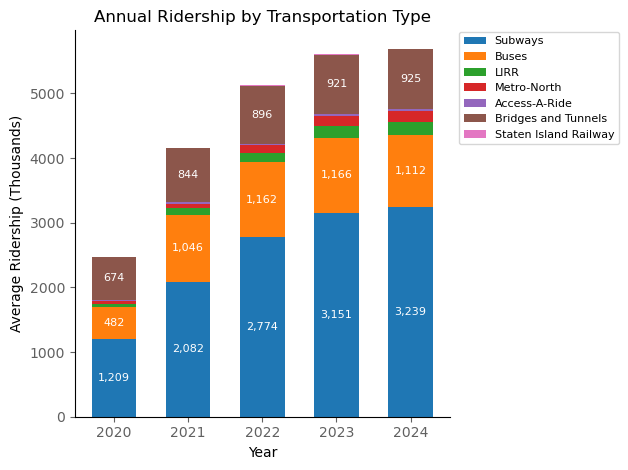

In [26]:
services_legend = [services,services]

fig, ax = plt.subplots()

# Initialize the bottom variable
bottom = np.zeros(len(annual_data))

# Plot stacked bars
for service in services:
    bars = ax.bar(
        annual_data['Year'],  # X-axis values (ensure it's a string)
        annual_data[service],  # Heights for each service
        bottom=bottom,  # Stack bars
        label=service,
        color=full_colours[services.index(service)],
        width=0.6  # Adjust bar width
    )

    # Add data labels for each bar
    for i, bar in enumerate(bars):
        if service in (['Subways','Buses','Bridges and Tunnels']):
            # Calculate the position for the label
            height = bar.get_height()  # Height of the bar
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # Center of the bar
                bottom[i] + height / 2,  # Middle of the bar segment
                f"{height:,.0f}",  # Format label to 0 decimal places
                ha='center',  # Center-align the text horizontally
                va='center',  # Center-align the text vertically
                fontsize=8,   # Adjust font size
                color='white'  # Adjust text color for contrast
        )
        
    bottom += annual_data[service]  # Update bottom for stacking

# Add labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Average Ridership (Thousands)')
ax.set_title('Annual Ridership by Transportation Type')

# Add legend
ax.legend(
    bbox_to_anchor=(1.01, 1.01),
    fontsize=8
)

# Align xticks with years
ax.set_xticks(annual_data['Year'])

# Commented out as ax.set_xticks(annual_data['Year']) is shorter and easier to understand
#ax.xticks=np.arange(    
#    min(annual_data['Year'].astype(int)),
#    max(annual_data['Year'].astype(int)),
#    step=1)

# Format axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='x', colors='#606060')
ax.tick_params(axis='y', colors='#606060')

plt.tight_layout()
plt.savefig('Annual Ridership by Transportation Type.png')
plt.show();


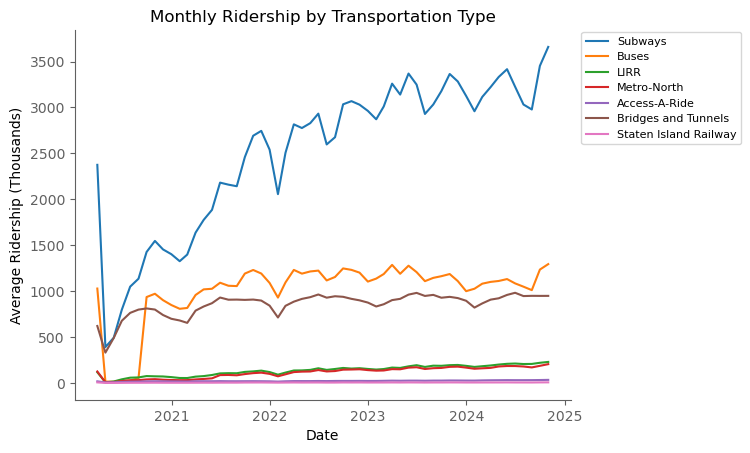

In [27]:
# Set the colours for all charts
full_colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
# Old Grey = #B3B3B3
colours = ['#1f77b4', '#CCCCCC', '#CCCCCC', '#CCCCCC', '#9467bd', '#CCCCCC', '#CCCCCC']
colours_pct = ['#CCCCCC', '#CCCCCC', '#CCCCCC', '#CCCCCC', '#9467bd', '#CCCCCC', '#e377c2']
fig, ax = plt.subplots()

services = ['Subways',
            'Buses',
            'LIRR',
            'Metro-North',
            'Access-A-Ride',
            'Bridges and Tunnels',
            'Staten Island Railway']

services_legend = [services,services]
for service in services:    
    ax.plot(
        monthly_data['Date'],
        monthly_data[service],  
        label=service,
        color=full_colours[services.index(service)]
    )    

ax.set_xlabel('Date')
ax.set_ylabel('Average Ridership (Thousands)')
ax.set_title('Monthly Ridership by Transportation Type')

handles, labels = services_legend

ax.legend(        
    bbox_to_anchor= (1.01,1.01),
    fontsize = 8
)
ax.xticks=np.arange(    
    min(monthly_data['Date'].dt.year),
    max(monthly_data['Date'].dt.year),
    step=1)

# Format the X & Y axes and remove the top and right borders

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_color('#606060')
ax.spines['bottom'].set_color('#606060')
ax.tick_params(axis='x', colors='#606060')  # X-axis ticks and labels
ax.tick_params(axis='y', colors='#606060')  # Y-axis ticks and labels

plt.show();

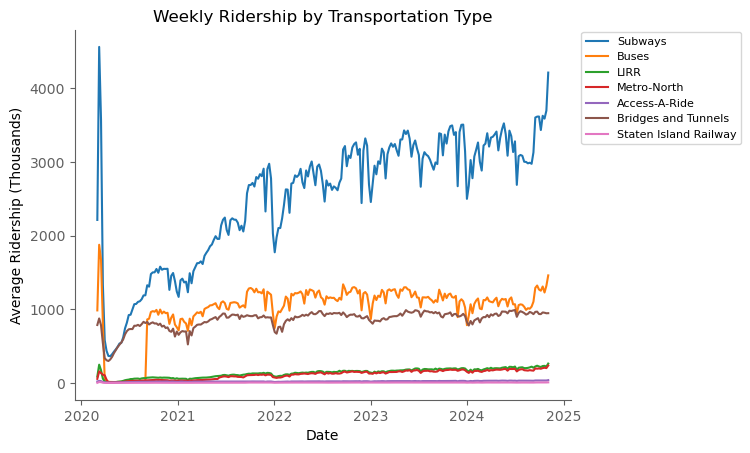

In [28]:
# Set the colours for all charts
full_colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
# Old Grey = #B3B3B3
colours = ['#1f77b4', '#CCCCCC', '#CCCCCC', '#CCCCCC', '#9467bd', '#CCCCCC', '#CCCCCC']
colours_pct = ['#CCCCCC', '#CCCCCC', '#CCCCCC', '#CCCCCC', '#9467bd', '#CCCCCC', '#e377c2']
fig, ax = plt.subplots()

services = ['Subways',
            'Buses',
            'LIRR',
            'Metro-North',
            'Access-A-Ride',
            'Bridges and Tunnels',
            'Staten Island Railway']

services_legend = [services,services]
for service in services:    
    ax.plot(
        weekly_data['Date'],
        weekly_data[service],  
        label=service,
        color=full_colours[services.index(service)]
    )    

ax.set_xlabel('Date')
ax.set_ylabel('Average Ridership (Thousands)')
ax.set_title('Weekly Ridership by Transportation Type')

handles, labels = services_legend

ax.legend(        
    bbox_to_anchor= (1.01,1.01),
    fontsize = 8
)
ax.xticks=np.arange(
    min(monthly_data['Date'].dt.year),
    max(monthly_data['Date'].dt.year),
    step=1)

# Format the X & Y axes and remove the top and right borders

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_color('#606060')
ax.spines['bottom'].set_color('#606060')
ax.tick_params(axis='x', colors='#606060')  # X-axis ticks and labels
ax.tick_params(axis='y', colors='#606060')  # Y-axis ticks and labels

plt.show();

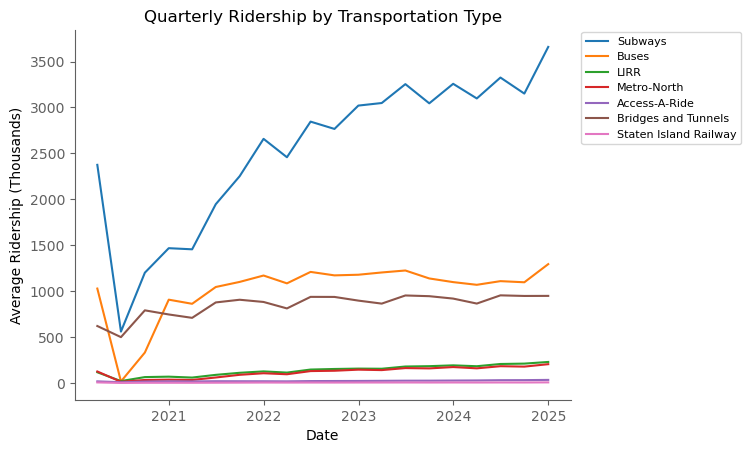

In [29]:
# Set the colours for all charts
full_colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
# Old Grey = #B3B3B3
colours = ['#1f77b4', '#CCCCCC', '#CCCCCC', '#CCCCCC', '#9467bd', '#CCCCCC', '#CCCCCC']
colours_pct = ['#CCCCCC', '#CCCCCC', '#CCCCCC', '#CCCCCC', '#9467bd', '#CCCCCC', '#e377c2']
fig, ax = plt.subplots()

services = ['Subways',
            'Buses',
            'LIRR',
            'Metro-North',
            'Access-A-Ride',
            'Bridges and Tunnels',
            'Staten Island Railway']

services_legend = [services,services]
for service in services:    
    ax.plot(
        quarterly_data['Date'],
        quarterly_data[service],  
        label=service,
        color=full_colours[services.index(service)]
    )    

ax.set_xlabel('Date')
ax.set_ylabel('Average Ridership (Thousands)')
ax.set_title('Quarterly Ridership by Transportation Type')

handles, labels = services_legend

ax.legend(        
    bbox_to_anchor= (1.01,1.01),
    fontsize = 8
)
ax.xticks=np.arange(
    min(monthly_data['Date'].dt.year),
    max(monthly_data['Date'].dt.year),
    step=1)

# Format the X & Y axes and remove the top and right borders

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_color('#606060')
ax.spines['bottom'].set_color('#606060')
ax.tick_params(axis='x', colors='#606060')  # X-axis ticks and labels
ax.tick_params(axis='y', colors='#606060')  # Y-axis ticks and labels

plt.show();

Subways: % of Pre-Pandemic
Buses: % of Pre-Pandemic
LIRR: % of Pre-Pandemic
Metro-North: % of Pre-Pandemic
Access-A-Ride: % of Pre-Pandemic
Bridges and Tunnels: % of Pre-Pandemic
Staten Island Railway: % of Pre-Pandemic


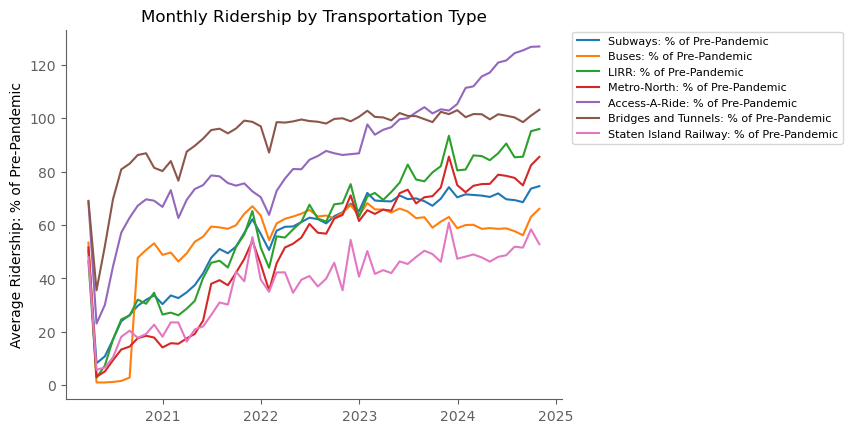

In [30]:
fig, ax = plt.subplots()

for service in services:    
    service_pct = f'{service}: % of Pre-Pandemic'  
    print(service_pct)
    ax.plot(
        monthly_data['Date'],
        monthly_data[service_pct],        
        label=f'{service}: % of Pre-Pandemic',
        #color=colours_pct[services.index(service)]
        color=full_colours[services.index(service)]
    )

#ax.set_xlabel('Date')
ax.set_ylabel('Average Ridership: % of Pre-Pandemic')
ax.set_title('Monthly Ridership by Transportation Type')
ax.xticks=np.arange(min(monthly_data['Date'].dt.year),max(monthly_data['Date'].dt.year),step=1)

handles, labels = services_legend
ax.legend(
   bbox_to_anchor= (1.01,1.01),
   fontsize = 8
)

# Format the X & Y axes and remove the top and right borders

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_color('#606060')
ax.spines['bottom'].set_color('#606060')
ax.tick_params(axis='x', colors='#606060')  # X-axis ticks and labels
ax.tick_params(axis='y', colors='#606060')  # Y-axis ticks and labels


plt.show();

In [31]:
quarterly_data.head()

,Date,Subways,Subways: % of Pre-Pandemic,Buses,Buses: % of Pre-Pandemic,LIRR,LIRR: % of Pre-Pandemic,Metro-North,Metro-North: % of Pre-Pandemic,Access-A-Ride,Access-A-Ride: % of Pre-Pandemic,Bridges and Tunnels,Bridges and Tunnels: % of Pre-Pandemic,Staten Island Railway,Staten Island Railway: % of Pre-Pandemic
0,2020-03-31,2375.064516,50.387097,1028.193548,53.419355,117.000000,46.387097,125.516129,51.580645,17.935484,68.548387,620.516129,69.032258,6.451613,47.967742
1,2020-06-30,559.659341,12.010989,16.923077,1.065934,21.032967,9.054945,13.186813,5.868132,8.428571,32.472527,499.340659,52.384615,0.923077,7.571429
2,2020-09-30,1201.043478,26.619565,331.608696,17.043478,64.434783,27.532609,32.978261,15.108696,15.804348,62.315217,791.065217,83.304348,2.315217,18.771739
3,2020-12-31,1467.804348,31.967391,907.293478,50.836957,69.054348,30.478261,36.641304,16.804348,18.032609,68.489130,746.217391,82.847826,2.510870,19.967391
4,2021-03-31,1455.488889,33.700000,862.355556,48.533333,59.277778,27.366667,33.433333,16.266667,17.111111,68.544444,709.344444,82.877778,2.411111,21.022222


Subways: % of Pre-Pandemic
Buses: % of Pre-Pandemic
LIRR: % of Pre-Pandemic
Metro-North: % of Pre-Pandemic
Access-A-Ride: % of Pre-Pandemic
Bridges and Tunnels: % of Pre-Pandemic
Staten Island Railway: % of Pre-Pandemic


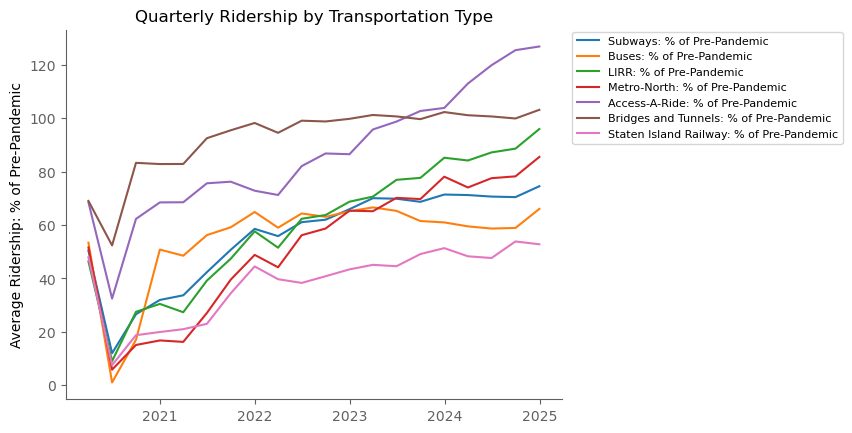

In [32]:

fig, ax = plt.subplots()

for service in services:    
    service_pct = f'{service}: % of Pre-Pandemic'  
    print(service_pct)
    ax.plot(
        quarterly_data['Date'],
        quarterly_data[service_pct],        
        label=f'{service}: % of Pre-Pandemic',
        #color=colours_pct[services.index(service)]
        color=full_colours[services.index(service)]
    )

#ax.set_xlabel('Date')
ax.set_ylabel('Average Ridership: % of Pre-Pandemic')
ax.set_title('Quarterly Ridership by Transportation Type')
ax.xticks=np.arange(min(quarterly_data['Date'].dt.year),max(quarterly_data['Date'].dt.year),step=1)

handles, labels = services_legend
ax.legend(
   bbox_to_anchor= (1.01,1.01),
   fontsize = 8
)

# Format the X & Y axes and remove the top and right borders

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_color('#606060')
ax.spines['bottom'].set_color('#606060')
ax.tick_params(axis='x', colors='#606060')  # X-axis ticks and labels
ax.tick_params(axis='y', colors='#606060')  # Y-axis ticks and labels


plt.show();

In [33]:
#Show the monthly_data for testing
monthly_data.head()

,Date,Subways,Subways: % of Pre-Pandemic,Buses,Buses: % of Pre-Pandemic,LIRR,LIRR: % of Pre-Pandemic,Metro-North,Metro-North: % of Pre-Pandemic,Access-A-Ride,Access-A-Ride: % of Pre-Pandemic,Bridges and Tunnels,Bridges and Tunnels: % of Pre-Pandemic,Staten Island Railway,Staten Island Railway: % of Pre-Pandemic
0,2020-03-31,2375.064516,50.387097,1028.193548,53.419355,117.000000,46.387097,125.516129,51.580645,17.935484,68.548387,620.516129,69.032258,6.451613,47.967742
1,2020-04-30,390.900000,8.233333,15.633333,1.000000,7.200000,2.833333,8.166667,3.166667,6.100000,23.066667,330.500000,35.533333,0.733333,5.766667
2,2020-05-31,492.741935,10.774194,13.258065,1.000000,16.161290,7.322581,10.806452,5.129032,7.580645,30.064516,490.612903,52.064516,0.645161,6.612903
3,2020-06-30,797.566667,17.066667,22.000000,1.200000,39.900000,17.066667,20.666667,9.333333,11.633333,44.366667,677.200000,69.566667,1.400000,10.366667
4,2020-07-31,1048.741935,23.967742,26.774194,1.580645,57.709677,24.645161,29.548387,13.354839,14.290323,57.161290,763.290323,80.838710,2.129032,18.129032


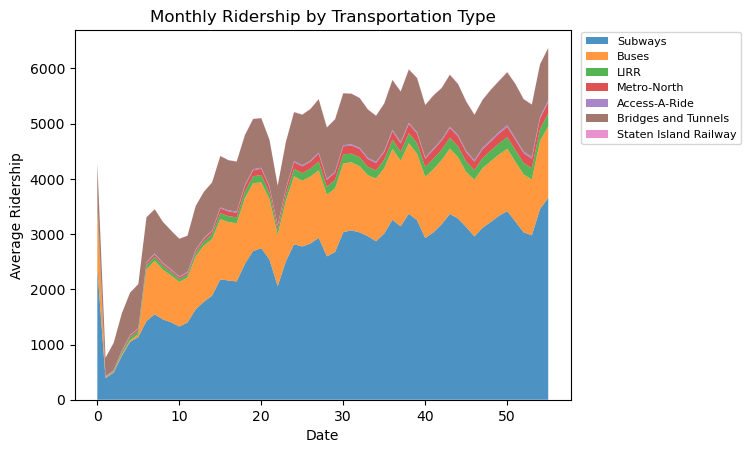

In [34]:
fig, ax = plt.subplots()
#full_colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
colours = ['#1f77b4', '#b0b0b0', '#b0b0b0', '#b0b0b0', '#b0b0b0', '#8c564b', '#b0b0b0']
services = ['Subways', 'Buses', 'LIRR', 'Metro-North', 'Access-A-Ride', 'Bridges and Tunnels', 'Staten Island Railway']
rider_data = monthly_data[services]
ax.stackplot(
    rider_data.index,
    rider_data.T,
    labels = services,
    colors = full_colours,
    alpha = 0.8        
);

ax.set_xlabel('Date')
ax.set_ylabel('Average Ridership')
ax.set_title('Monthly Ridership by Transportation Type')

handles, labels = ax.get_legend_handles_labels()
ax.legend(
   bbox_to_anchor= (1.01,1.01),fontsize = 8
)

#ax.legend()  # Displays the legend for each series

plt.show();

#### Create KPI Visuals

In [36]:
# Select the recovery percentage columns
recovery_columns = [
    'Subways: % of Pre-Pandemic', 'Buses: % of Pre-Pandemic', 'LIRR: % of Pre-Pandemic',
    'Metro-North: % of Pre-Pandemic', 'Access-A-Ride: % of Pre-Pandemic',
    'Bridges and Tunnels: % of Pre-Pandemic', 'Staten Island Railway: % of Pre-Pandemic'
]
monthly_data = monthly_data[recovery_columns]
quarterly_data = quarterly_data[recovery_columns]

In [37]:
# Get the last month or quarter data to display as the latest KPI values
latest_month = monthly_data.iloc[-1]
latest_quarter = quarterly_data.iloc[-1]

# Example: Print KPI indicators for the latest month
for service, recovery in latest_month.items():
    status = "⬆️" if recovery >= 90 else ("➡️" if 50 <= recovery < 90 else "⬇️")
    print(f"{service}: {recovery:.2f}% of Pre-Pandemic {status}")

Subways: % of Pre-Pandemic: 74.55% of Pre-Pandemic ➡️
Buses: % of Pre-Pandemic: 66.06% of Pre-Pandemic ➡️
LIRR: % of Pre-Pandemic: 95.97% of Pre-Pandemic ⬆️
Metro-North: % of Pre-Pandemic: 85.52% of Pre-Pandemic ➡️
Access-A-Ride: % of Pre-Pandemic: 126.87% of Pre-Pandemic ⬆️
Bridges and Tunnels: % of Pre-Pandemic: 103.16% of Pre-Pandemic ⬆️
Staten Island Railway: % of Pre-Pandemic: 52.81% of Pre-Pandemic ➡️


In [38]:
latest_month.info()

<class 'pandas.core.series.Series'>
Index: 7 entries, Subways: % of Pre-Pandemic to Staten Island Railway: % of Pre-Pandemic
Series name: 55
Non-Null Count  Dtype  
--------------  -----  
7 non-null      float64
dtypes: float64(1)
memory usage: 112.0+ bytes


<Figure size 640x480 with 0 Axes>

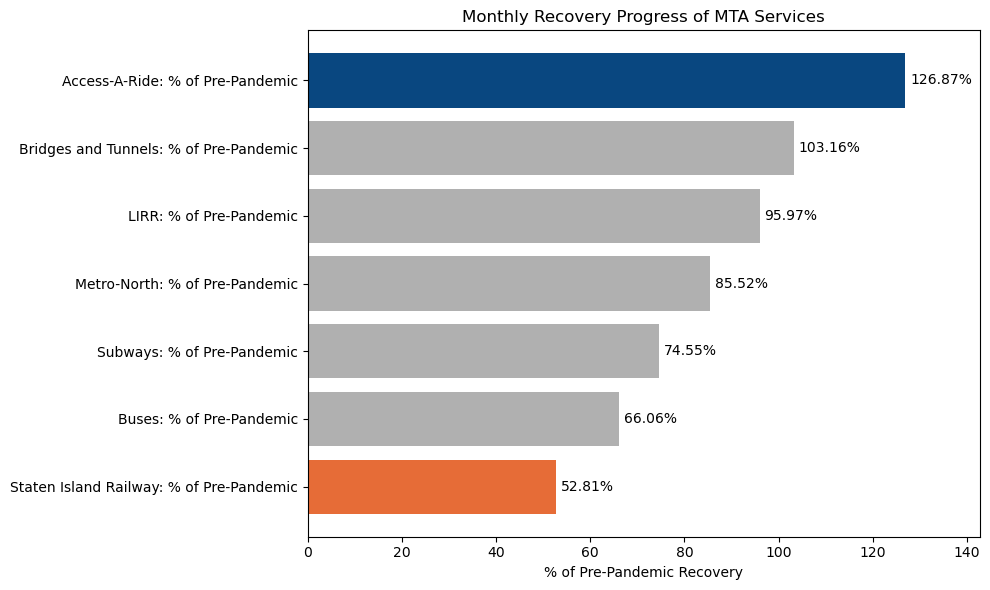

In [39]:
# Get the maximum recovery value to set the colour of the highest value
# It is strange that to get the chart to show with the highest value at the top
# I need to set ascending=True not ascending=False.

latest_month = latest_month.sort_values(ascending=True)
max_recovery = 0
min_recovery = 9999
for recovery in latest_month:
    if recovery > max_recovery:
        max_recovery = recovery
    if recovery < min_recovery:
        min_recovery = recovery
        
group_colours = [
    "#094780" if recovery == max_recovery
    else "#e66c37" if recovery == min_recovery
    else '#b0b0b0' for recovery in latest_month]

# Original code showing grouped colour banding
#group_colours = [
#    "#e1c233" if recovery == max_recovery
#    else "#D9534F" if recovery < 60 
#    else "#F0AD4E" if recovery < 90 
#    else "#5CB85C" for recovery in latest_month]

fig = plt.figure(constrained_layout=True)
fig = plt.figure(figsize=(10, 6))

# Plot the KPI indicators as a bar chart
plt.barh(
    latest_month.index, 
    latest_month.values, 
    color=group_colours
)
plt.xlabel('% of Pre-Pandemic Recovery')
plt.title('Monthly Recovery Progress of MTA Services')
plt.xlim(0,recovery*1.125) # Give a 20 buffer to maximum recovery value to allow for data labels to fit into chart
# Add value labels to each bar
for index, value in enumerate(latest_month.values):
    plt.text(value + 1, index, f"{value:.2f}%", va='center')

plt.tight_layout()
plt.savefig('Recovery Progress.png')
plt.show();


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1706 entries, 2020-03-01 to 2024-10-31
Data columns (total 14 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Subways                                   1706 non-null   float64
 1   Subways: % of Pre-Pandemic                1706 non-null   int64  
 2   Buses                                     1706 non-null   float64
 3   Buses: % of Pre-Pandemic                  1706 non-null   int64  
 4   LIRR                                      1706 non-null   float64
 5   LIRR: % of Pre-Pandemic                   1706 non-null   int64  
 6   Metro-North                               1706 non-null   float64
 7   Metro-North: % of Pre-Pandemic            1706 non-null   int64  
 8   Access-A-Ride                             1706 non-null   float64
 9   Access-A-Ride: % of Pre-Pandemic          1706 non-null   int64  
 10  Bridges and Tunnel

,Date,Subways: % of Pre-Pandemic
0,2020-03-31,50
1,2020-04-30,8
2,2020-05-31,11
3,2020-06-30,17
4,2020-07-31,24


df_service
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        56 non-null     datetime64[ns]
 1   Subways: % of Pre-Pandemic  56 non-null     int32         
 2   days_since_start            56 non-null     int64         
 3   month                       56 non-null     int32         
 4   month_sin                   56 non-null     float64       
 5   month_cos                   56 non-null     float64       
 6   lag_1                       56 non-null     float64       
 7   lag_2                       56 non-null     float64       
 8   lag1_month_sin_interaction  56 non-null     float64       
 9   lag1_month_cos_interaction  56 non-null     float64       
dtypes: datetime64[ns](1), float64(6), int32(2), int64(1)
memory usage: 4.1 KB
None
----------------------------------

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.01, 0.1, 1, 2.6, 2.61, 2.62, 2.63, 2.64,
                                   2.65, 2.7, 2.9, 3, 3.1, 3.2, 3.3, 3.4, 3.5,
                                   3.56, 3.565, 3.566, 3.567, 4, 10, 100,
                                   1000]},
             scoring='neg_mean_absolute_error')

Best alpha: 3.56
Best CV MAE: 4.982871311656529


Ridge(alpha=3.56)

ridge model score


0.900935082196817

intercept: 56.87711794094804
slope: [ 9.60108781 -1.55919305  0.5619788   9.13241284 -0.2278599   0.97459837
  0.09313516]
--------------------------------------------------------------------------------
MAE: 6.593217057757529
MSE: 48.933609219014365
MPE: -9.292820779871834
MAPE: -9.292820779871834
RMSE: 6.995256193951324
Baseline MAE: 20.196969696969703


Text(0.5, 1.0, 'Linear Regression: Subways: % of Pre-Pandemic')

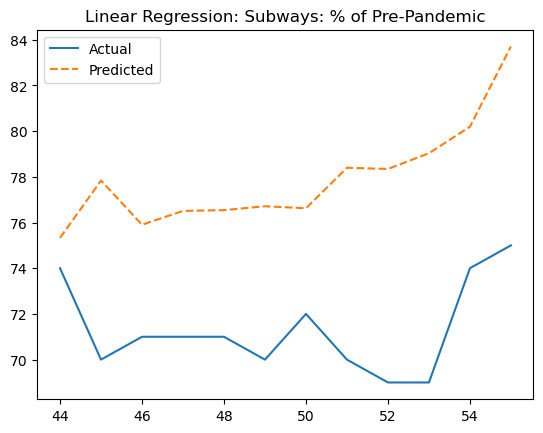

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from math import sqrt

def get_forecast_index(test_index, period, granularity):
    """Generate forecast index based on granularity."""
    last_date = test_index[-1]
    if granularity == 'Day':
        return pd.date_range(start=last_date + pd.Timedelta(1, 'D'), periods=period, freq='D')
    elif granularity == 'Week':
        return pd.date_range(start=last_date + pd.Timedelta(7, 'D'), periods=period, freq='W')
    elif granularity == 'Month':
        return pd.date_range(start=last_date + pd.DateOffset(months=1), periods=period, freq='ME')
    elif granularity == 'Quarter':
        return pd.date_range(start=last_date + pd.DateOffset(months=3), periods=period, freq='QE')
    elif granularity == 'Year':
        return pd.date_range(start=last_date + pd.DateOffset(years=1), periods=period, freq='YE')
    raise ValueError(f"Unsupported granularity: {granularity}")
    
# Frequency mappings
freq_mapping = {
    'Day': None,
    'Week': 'W',
    'Month': 'ME',
    'Quarter': 'QE',
    'Year': 'YE'
}
period_mapping = {
    'Day': 365, 
    'Week': 52, 
    'Month': 12, 
    'Quarter': 4, 
    'Year': 1
}

# User-selected granularity
granularity = 'Month'
period = period_mapping.get(granularity, 12)

mta_thousands = create_thousand_dataframe(mta_data)
mta_thousands.set_index('Date',inplace=True)
print(mta_thousands.info())
print(mta_thousands.shape)

granular_data = resample_data(mta_thousands, granularity)

#service = 'Subways'
service = 'Subways: % of Pre-Pandemic'
df_service = granular_data[[service]].copy()
print('df_service')
print(df_service.info())
print('-' * 80)
# Reset index to access the date
df_service = df_service.reset_index()
df_service.head()
# Create a numeric representation of the date
df_service['days_since_start'] = (df_service['Date'] - df_service['Date'].min()).dt.days

# Extract month and create cyclic features
df_service['month'] = df_service['Date'].dt.month
#df_service['month_sin'] = np.sin(2 * np.pi * df_service['month'] / 12)
#df_service['month_cos'] = np.cos(2 * np.pi * df_service['month'] / 12)

df_service['month_sin'] = np.sin(2 * np.pi * df_service['Date'].dt.month / 12)
df_service['month_cos'] = np.cos(2 * np.pi * df_service['Date'].dt.month / 12)

df_service['lag_1'] = df_service['Subways: % of Pre-Pandemic'].shift(1)  # Lag by 1 month
df_service['lag_2'] = df_service['Subways: % of Pre-Pandemic'].shift(2)  # Lag by 2 months

#df_service['lag_1'] = df_service['Subways: % of Pre-Pandemic'].shift(1)  # Lag by 1 month
#df_service['lag_2'] = df_service['Subways: % of Pre-Pandemic'].shift(2)  # Lag by 2 months
#df_service['lag_3'] = df_service['Subways: % of Pre-Pandemic'].shift(3)  # Lag by 2 months
#df_service['lag_4'] = df_service['Subways: % of Pre-Pandemic'].shift(4)  # Lag by 2 months
df_service['lag_1'] = df_service['lag_1'].fillna(df_service['lag_1'].median())
df_service['lag_2'] = df_service['lag_2'].fillna(df_service['lag_2'].median())
#df_service['lag_3'] = df_service['lag_3'].fillna(df_service['lag_3'].median())
#df_service['lag_4'] = df_service['lag_4'].fillna(df_service['lag_4'].median())
df_service['lag1_month_sin_interaction'] = df_service['lag_1'] * df_service['month_sin']
df_service['lag1_month_cos_interaction'] = df_service['lag_1'] * df_service['month_cos']
#df_service['month'] = df_service.index.month
#df_service = pd.get_dummies(df_service, columns=['month'], drop_first=True)  # One-hot encoding
#df_service['lag1_lag2_interaction'] = df_service['lag_1'] * df_service['lag_2']

#print('df_service after get dummies')
#print(df_service.info())
#print('-' * 80)

print('df_service')
print(df_service.info())
print('-' * 80)
# Prepare final features and target
X = df_service[['days_since_start', 'month_sin', 'month_cos', 'lag_1','lag_2',
               'lag1_month_sin_interaction',
               'lag1_month_cos_interaction',]] #'lag_2','lag_3', 'lag_4']]
y = df_service[service]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

alpha_range = [0.01, 
               0.1, 
               1, 
               2.6, 
               2.61, 
               2.62, 
               2.63, 
               2.64, 
               2.65, 
               2.7, 
               2.9, 
               3, 
               3.1,
               3.2,
               3.3,
               3.4,
               3.5,
               3.56,
               3.565,
               3.566,
               3.567,
               4,
               10, 100, 1000]
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, param_grid={'alpha': alpha_range}, scoring='neg_mean_absolute_error', cv=5)

ridge_cv.fit(X_train_scaled, y_train)

# Best alpha and corresponding score
print("Best alpha:", ridge_cv.best_params_['alpha'])
print("Best CV MAE:", -ridge_cv.best_score_)

#model = LinearRegression()
#model.fit(X_train, y_train)

model = Ridge(alpha=ridge_cv.best_params_['alpha'])  # Experiment with alpha
model.fit(X_train_scaled, y_train)

print('ridge model score')
model.score(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mpe = np.mean((y_test - y_pred) / y_test) * 100
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
rmse = sqrt(mean_squared_error(y_test, y_pred))


print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")
print('-'*80)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'MPE: {mpe}')
print(f'MAPE: {mpe}')
print(f'RMSE: {rmse}')

baseline_mae = mean_absolute_error(y_test, [y_train.mean()] * len(y_test))
print(f'Baseline MAE: {baseline_mae}')


plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted', linestyle='dashed')
plt.legend()
plt.title(f'Linear Regression: {service}')
plt.show()

Text(0.5, 0, 'Predicted Values')

Text(0, 0.5, 'Residuals')

Text(0.5, 1.0, 'Residual Plot')

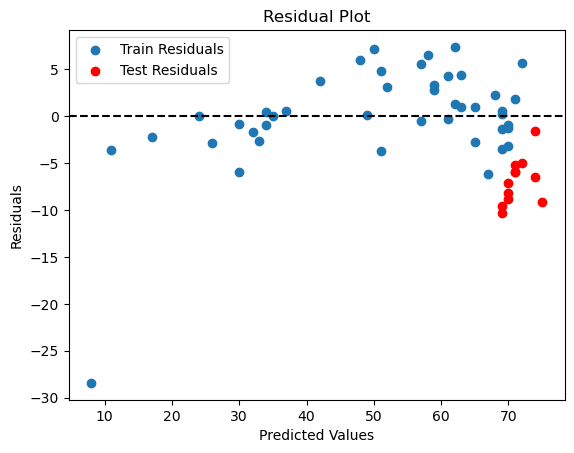

In [41]:
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

plt.scatter(y_train, y_train - y_train_pred, label="Train Residuals")
plt.scatter(y_test, y_test - y_test_pred, label="Test Residuals", color='red')
plt.axhline(0, linestyle='--', color='black')
plt.legend()
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Residuals')

Text(0.5, 1.0, 'Residuals Over Time')

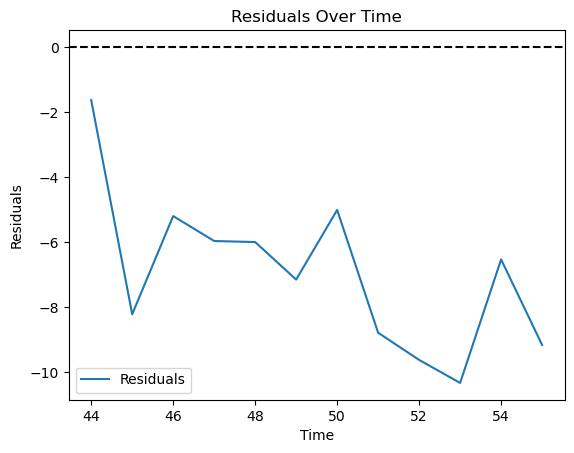

In [42]:
plt.plot(y_test.index, y_test - y_test_pred, label="Residuals")
plt.axhline(0, linestyle='--', color='black')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.title("Residuals Over Time")
plt.show()

<Axes: xlabel='Date'>

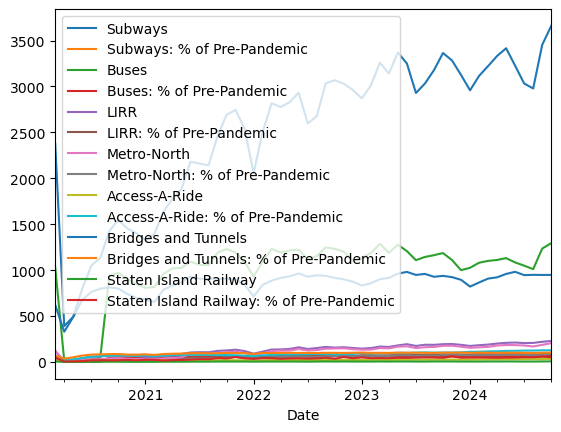

In [43]:
granular_data.plot()

In [44]:
granular_data.head()

,Subways,Subways: % of Pre-Pandemic,Buses,Buses: % of Pre-Pandemic,LIRR,LIRR: % of Pre-Pandemic,Metro-North,Metro-North: % of Pre-Pandemic,Access-A-Ride,Access-A-Ride: % of Pre-Pandemic,Bridges and Tunnels,Bridges and Tunnels: % of Pre-Pandemic,Staten Island Railway,Staten Island Railway: % of Pre-Pandemic
Date,,,,,,,,,,,,,,
2020-03-31,2375,50,1028,53,117,46,126,52,18,69,621,69,6,48
2020-04-30,391,8,16,1,7,3,8,3,6,23,330,36,1,6
2020-05-31,493,11,13,1,16,7,11,5,8,30,491,52,1,7
2020-06-30,798,17,22,1,40,17,21,9,12,44,677,70,1,10
2020-07-31,1049,24,27,2,58,25,30,13,14,57,763,81,2,18


In [45]:
print(granular_data.index.freq)

<MonthEnd>


In [46]:
#seasonal_decompose(x, model='additive', filt=None, freq=52)
df_seasonal = granular_data.apply(lambda x: seasonal_decompose(x, model='additive').trend)
#result = seasonal_decompose(granular_data,model='additive', filt=None, period=12).plot

<Axes: xlabel='Date'>

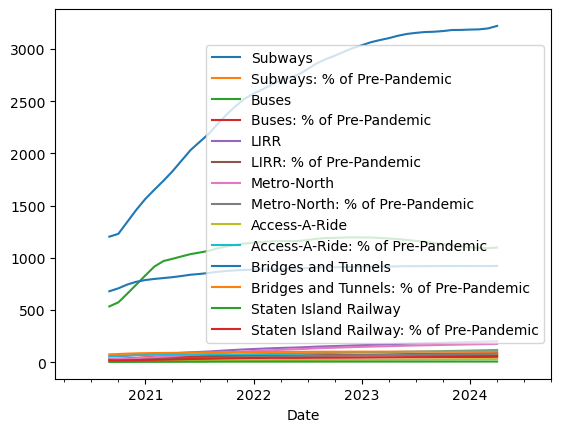

In [47]:
df_seasonal.plot()